In [78]:
import os
import warnings
import statistics
import numpy as np
import pandas as pd
import scipy as scipy
import seaborn as sns
from scipy import stats
from dotenv import load_dotenv
from pymongo import MongoClient
import matplotlib.pyplot as plt
from datetime import timedelta
from dataprep.eda import create_report
from pandas.core.common import SettingWithCopyWarning

cmap='seismic'
sns.set_palette(sns.color_palette(cmap))

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

Connect securely to the database

In [79]:
load_dotenv("config.env")
MONGO_USER = os.getenv("MONGO_USER")
MONGO_PASSWORD = os.getenv("MONGO_PASSWORD")
client = MongoClient("mongodb://" + MONGO_USER + ":" + MONGO_PASSWORD + "@localhost:27017/")
database = client.rais

Find all the users

In [80]:
users = database.fitbit.distinct('id')

Create the fitbit dataframe

In [81]:
stress_df = pd.DataFrame(columns=["id", "date", "stress_score"])

for user in users:
    # obtain the stress data
    user_data = pd.DataFrame(list(
        database.fitbit.find({"$and": [
            {"type": "Stress Score"},
            {"id": user},
            {"data.STRESS_SCORE": {"$gt": 0}} # this removes the calculation fail data (0s)
        ]},
            {"id": 1, "data.DATE": 1, "data.STRESS_SCORE": 1, "_id": 0}
        )
    ))

    # maintain only the users that have stress data / avoid the others
    if len(user_data.columns)>1:
        user_stress = pd.DataFrame(columns=["date", "stress_score"])
        user_stress["date"] = user_data["data"].apply(lambda d: d["DATE"])
        user_stress["date"] = pd.to_datetime(pd.to_datetime(user_stress["date"]).dt.date)
        user_stress["stress_score"] = user_data["data"].apply(lambda d: d["STRESS_SCORE"])

        # maintain only experiment's dates
        user_stress = user_stress.loc[((user_stress['date'] >'2021-05-23') & (user_stress['date'] <'2021-07-27')) | ((user_stress['date'] >'2021-11-14') & (user_stress['date'] <'2022-01-18'))]
        user_stress.reset_index(inplace=True, drop=True)

        # remove duplicates # there are no outliers
        user_stress = user_stress.groupby(["date"]).first()
        user_stress.reset_index(inplace=True)

        # >=2 in order to have enough real data
        if len(user_stress)>=2:
            # resampling with weekly frequency that avoids 0s/NaNs
            user_stress = user_stress.set_index('date')
            user_stress = user_stress.resample('W-SUN').median()
            user_stress.reset_index(inplace=True)
            user_stress.insert(0, "id", user)

            # shift the date column one day after for better representation
            user_stress['date'] = user_stress['date'].apply(lambda x:x+timedelta(days=1))

            # check if each value in date column is Monday (SUCCESS)
            # for day in list(user_stress['date']):
            #     if day.weekday()!=0:
            #         print("no Monday")

            # keep only experiment's dates / for the one that has 218 days
            user_stress = user_stress.loc[((user_stress['date'] >'2021-05-23') & (user_stress['date'] <'2021-07-27')) | ((user_stress['date'] >'2021-11-14') & (user_stress['date'] <'2022-01-18'))]
            user_stress.reset_index(inplace=True, drop=True)

            # drop NaNs & 0s that were created from resampling
            user_stress.dropna(inplace=True)
            user_stress = user_stress[user_stress.stress_score != 0]
            user_stress.reset_index(inplace=True, drop=True)

            # cut to 2 decimals the stress scores and make them float
            user_stress['stress_score'] = user_stress['stress_score'].apply(lambda x:format(x,".2f"))
            user_stress['stress_score'] = pd.to_numeric(user_stress['stress_score'])

            # user average stress score and mean_variation, median_variation, passive_median_variation
            user_stress['average_stress_score'] = statistics.mean(list(user_stress['stress_score']))
            user_stress['median_stress_score'] = statistics.median(list(user_stress['stress_score']))
            user_stress['mean_variation'] = user_stress['stress_score'] - user_stress['average_stress_score']
            user_stress['median_variation'] = user_stress['stress_score'] - user_stress['median_stress_score']
            values = []
            user_stress['passive_median_stress_score'] = 0
            for it in range(len(user_stress['stress_score'])):
                values.append(user_stress['stress_score'][it])
                user_stress['passive_median_stress_score'][it] = statistics.mean(values)
            user_stress['passive_median_variation'] = user_stress['stress_score'] - user_stress['passive_median_stress_score']

            stress_df = pd.concat([stress_df, user_stress], axis=0)
stress_df["id"] = stress_df["id"].apply(lambda t: str(t))
stress_df["date"] = pd.to_datetime(pd.to_datetime(stress_df["date"]).dt.date)
stress_df

,id,date,stress_score,average_stress_score,median_stress_score,mean_variation,median_variation,passive_median_stress_score,passive_median_variation
0,621e2e8e67b776a24055b564,2021-05-31,81.0,75.944444,75.0,5.055556,6.0,81.000000,0.000000
1,621e2e8e67b776a24055b564,2021-06-07,83.0,75.944444,75.0,7.055556,8.0,82.000000,1.000000
2,621e2e8e67b776a24055b564,2021-06-14,74.0,75.944444,75.0,-1.944444,-1.0,79.333333,-5.333333
3,621e2e8e67b776a24055b564,2021-06-21,76.0,75.944444,75.0,0.055556,1.0,78.500000,-2.500000
4,621e2e8e67b776a24055b564,2021-06-28,76.0,75.944444,75.0,0.055556,1.0,78.000000,-2.000000
...,...,...,...,...,...,...,...,...,...
4,621e375b67b776a240290cdc,2021-06-28,80.0,79.277778,80.0,0.722222,0.0,78.700000,1.300000
5,621e375b67b776a240290cdc,2021-07-05,78.0,79.277778,80.0,-1.277778,-2.0,78.583333,-0.583333
6,621e375b67b776a240290cdc,2021-07-12,76.0,79.277778,80.0,-3.277778,-4.0,78.214286,-2.214286
7,621e375b67b776a240290cdc,2021-07-19,84.0,79.277778,80.0,4.722222,4.0,78.937500,5.062500


Create the stai dataframe

In [82]:
stai_df = pd.read_csv('./data/stai.csv')
stai_df = stai_df.iloc[: , 1:-1]
stai_df.drop(["type"], axis=1, inplace=True)
stai_df.rename(columns={"user_id": "id", "submitdate": "date"}, inplace=True)
stai_df["date"] = pd.to_datetime(pd.to_datetime(stai_df["date"]).dt.date)
stai_df

,id,date,stai_stress
0,621e2e8e67b776a24055b564,2021-05-31,45.0
1,621e2e8e67b776a24055b564,2021-06-07,46.0
2,621e2e8e67b776a24055b564,2021-06-28,54.0
3,621e2e8e67b776a24055b564,2021-07-19,46.0
4,621e2e8e67b776a24055b564,2021-07-26,46.0
...,...,...,...
274,621e375b67b776a240290cdc,2021-06-01,59.0
275,621e375b67b776a240290cdc,2021-06-08,60.0
276,621e375b67b776a240290cdc,2021-06-22,60.0
277,621e375b67b776a240290cdc,2021-07-06,60.0


In [83]:
# check if each value in date column is Monday (FAILED)
count=0
for day in list(stai_df['date']):
    if day.weekday()!=0:
        count=count+1
count

120

Create the panas dataframe

In [84]:
panas_df = pd.read_csv('./data/panas.csv')
panas_df = panas_df.iloc[: , 1:]
panas_df.drop(["type"], axis=1, inplace=True)
panas_df.rename(columns={"user_id": "id", "submitdate": "date"}, inplace=True)
panas_df["date"] = pd.to_datetime(pd.to_datetime(panas_df["date"]).dt.date)
panas_df

,id,date,positive_affect_score,negative_affect_score
0,621e2e8e67b776a24055b564,2021-07-26,37,14
1,621e2e8e67b776a24055b564,2021-05-31,38,12
2,621e2e8e67b776a24055b564,2021-06-07,37,12
3,621e2e8e67b776a24055b564,2021-06-28,31,12
4,621e2e8e67b776a24055b564,2021-07-19,37,12
...,...,...,...,...
263,621e375367b776a24021e950,2022-01-02,30,33
264,621e375b67b776a240290cdc,2021-06-01,27,29
265,621e375b67b776a240290cdc,2021-06-08,30,30
266,621e375b67b776a240290cdc,2021-06-22,30,30


In [85]:
# check if each value in date column is Monday (FAILED)
count=0
for day in list(panas_df['date']):
    if day.weekday()!=0:
        count=count+1
count

113

Merge fitbit and stai dataframe

In [86]:
df_fitbit_stai = stress_df.merge(stai_df, how='left', on=['id', 'date'])
# remove NaNs (no existence of stress score or surveys' response)
df_fitbit_stai.dropna(inplace=True)
df_fitbit_stai.reset_index(inplace=True, drop=True)
df_fitbit_stai['stress_score'] = pd.to_numeric(df_fitbit_stai['stress_score'])
df_fitbit_stai

,id,date,stress_score,average_stress_score,median_stress_score,mean_variation,median_variation,passive_median_stress_score,passive_median_variation,stai_stress
0,621e2e8e67b776a24055b564,2021-05-31,81.0,75.944444,75.0,5.055556,6.0,81.000000,0.000000,45.0
1,621e2e8e67b776a24055b564,2021-06-07,83.0,75.944444,75.0,7.055556,8.0,82.000000,1.000000,46.0
2,621e2e8e67b776a24055b564,2021-06-28,76.0,75.944444,75.0,0.055556,1.0,78.000000,-2.000000,54.0
3,621e2e8e67b776a24055b564,2021-07-19,75.0,75.944444,75.0,-0.944444,0.0,76.187500,-1.187500,46.0
4,621e2e8e67b776a24055b564,2021-07-26,74.0,75.944444,75.0,-1.944444,-1.0,75.944444,-1.944444,46.0
...,...,...,...,...,...,...,...,...,...,...
83,621e36f967b776a240e5e7c9,2021-06-28,76.0,80.555556,82.0,-4.555556,-6.0,79.200000,-3.200000,45.0
84,621e36f967b776a240e5e7c9,2021-07-05,82.0,80.555556,82.0,1.444444,0.0,79.666667,2.333333,49.0
85,621e36f967b776a240e5e7c9,2021-07-12,83.0,80.555556,82.0,2.444444,1.0,80.142857,2.857143,50.0
86,621e36f967b776a240e5e7c9,2021-07-26,85.0,80.555556,82.0,4.444444,3.0,80.555556,4.444444,48.0


Merge fitbit and panas dataframe

In [87]:
df_fitbit_panas = stress_df.merge(panas_df, how='left', on=['id', 'date'])
# remove NaNs (no existence of stress score or surveys' response)
df_fitbit_panas.dropna(inplace=True)
df_fitbit_panas.reset_index(inplace=True, drop=True)
df_fitbit_panas['stress_score'] = pd.to_numeric(df_fitbit_panas['stress_score'])
df_fitbit_panas

,id,date,stress_score,average_stress_score,median_stress_score,mean_variation,median_variation,passive_median_stress_score,passive_median_variation,positive_affect_score,negative_affect_score
0,621e2e8e67b776a24055b564,2021-05-31,81.0,75.944444,75.0,5.055556,6.0,81.000000,0.000000,38.0,12.0
1,621e2e8e67b776a24055b564,2021-06-07,83.0,75.944444,75.0,7.055556,8.0,82.000000,1.000000,37.0,12.0
2,621e2e8e67b776a24055b564,2021-06-28,76.0,75.944444,75.0,0.055556,1.0,78.000000,-2.000000,31.0,12.0
3,621e2e8e67b776a24055b564,2021-07-19,75.0,75.944444,75.0,-0.944444,0.0,76.187500,-1.187500,37.0,12.0
4,621e2e8e67b776a24055b564,2021-07-26,74.0,75.944444,75.0,-1.944444,-1.0,75.944444,-1.944444,37.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...
79,621e36f967b776a240e5e7c9,2021-06-21,79.0,80.555556,82.0,-1.555556,-3.0,80.000000,-1.000000,17.0,27.0
80,621e36f967b776a240e5e7c9,2021-06-28,76.0,80.555556,82.0,-4.555556,-6.0,79.200000,-3.200000,28.0,24.0
81,621e36f967b776a240e5e7c9,2021-07-05,82.0,80.555556,82.0,1.444444,0.0,79.666667,2.333333,36.0,17.0
82,621e36f967b776a240e5e7c9,2021-07-12,83.0,80.555556,82.0,2.444444,1.0,80.142857,2.857143,34.0,18.0


Scatter plot with fitbit and stai

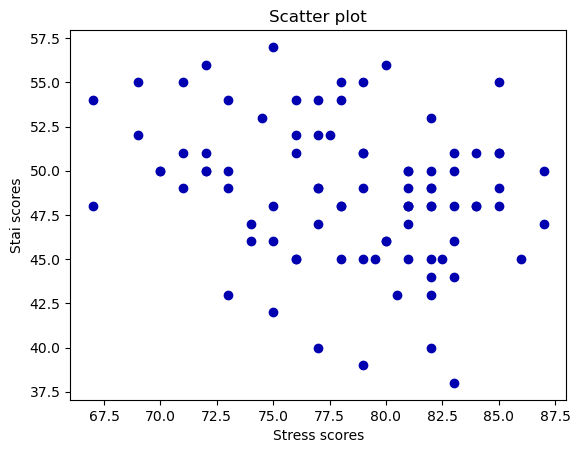

In [88]:
stress_scores = list(df_fitbit_stai['stress_score'])
stai_scores = list(df_fitbit_stai['stai_stress'])

plt.scatter(stress_scores, stai_scores)
plt.xlabel("Stress scores")
plt.ylabel("Stai scores")
plt.title("Scatter plot")
plt.show()

Correlation matrix between fitbit and stai

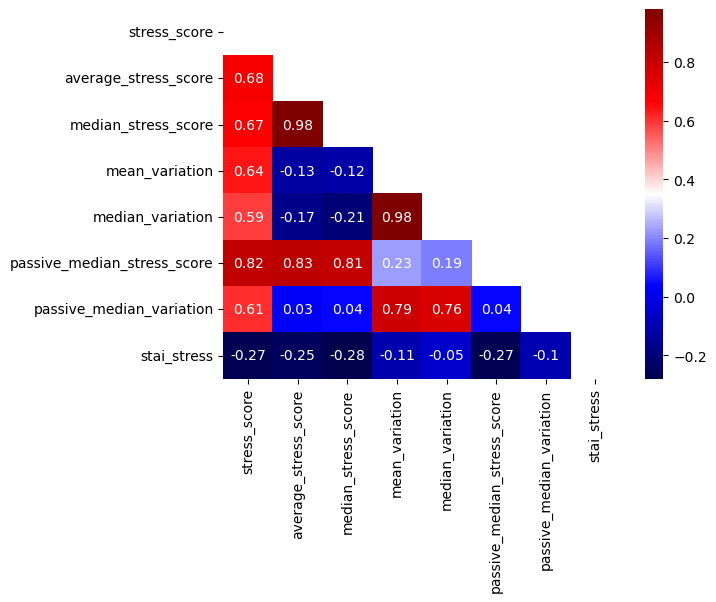

In [89]:
correlation_matrix = df_fitbit_stai.corr().round(2)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(data=correlation_matrix, annot=True,cmap=cmap,mask=mask)

Scatter plot with fitbit and panas positive

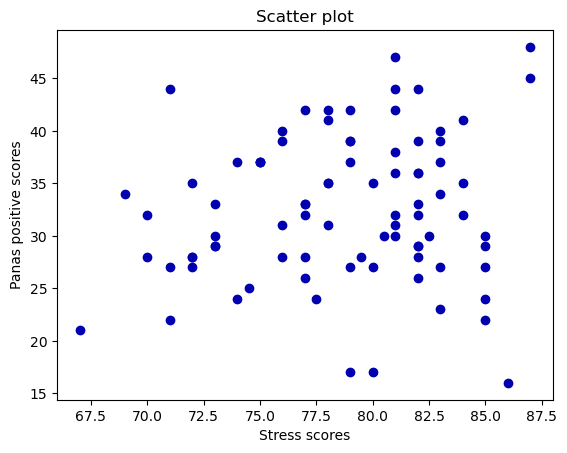

In [90]:
panas_positive_scores = list(df_fitbit_panas['positive_affect_score'])
stress_scores = list(df_fitbit_panas['stress_score'])

plt.scatter(stress_scores, panas_positive_scores)
plt.xlabel("Stress scores")
plt.ylabel("Panas positive scores")
plt.title("Scatter plot")
plt.show()

Scatter plot with fitbit and panas negative

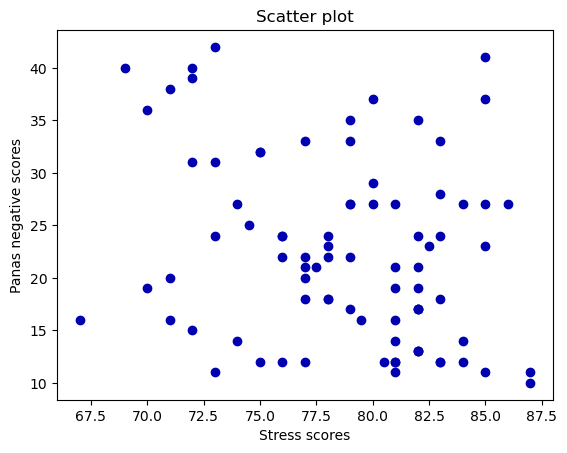

In [91]:
panas_negative_scores = list(df_fitbit_panas['negative_affect_score'])

plt.scatter(stress_scores, panas_negative_scores)
plt.xlabel("Stress scores")
plt.ylabel("Panas negative scores")
plt.title("Scatter plot")
plt.show()

Correlation matrix between fitbit and panas

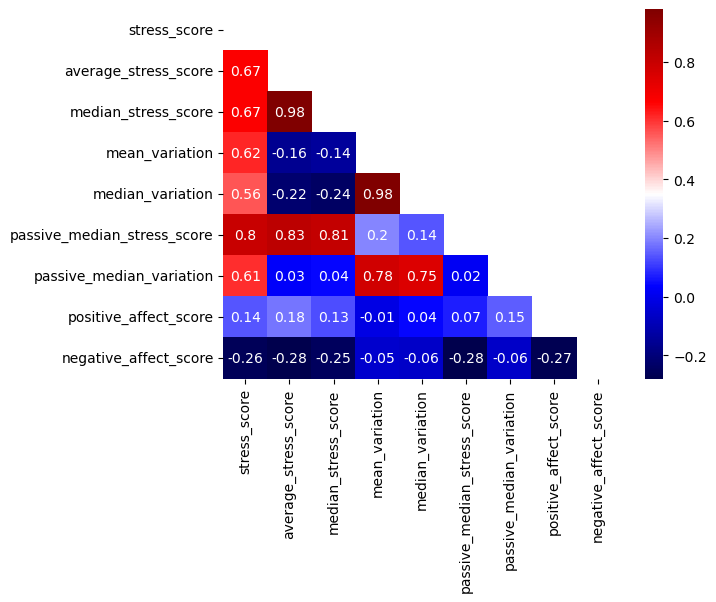

In [92]:
correlation_matrix = df_fitbit_panas.corr().round(2)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(data=correlation_matrix, annot=True,cmap=cmap,mask=mask)

Extra analysis/visualizations

In [93]:
create_report(df_fitbit_stai).show_browser()
create_report(df_fitbit_panas).show_browser()

  0%|          | 0/1701 [00:00<?, ?it/s]

C:\Users\evapa\miniconda3\envs\RAIS-miniproject\lib\site-packages\dataprep\eda\distribution\render.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({col: [nrows - npresent]}, index=["Others"]))


  0%|          | 0/1907 [00:00<?, ?it/s]

C:\Users\evapa\miniconda3\envs\RAIS-miniproject\lib\site-packages\dataprep\eda\distribution\render.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({col: [nrows - npresent]}, index=["Others"]))
